In [1]:
import numpy as np
import random
import math
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

In [2]:
class Layer:
    """
    The base layer class for all layers

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer

    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name):
        """
        The constructor for the layer class

        Parameters:
            name: The name of the layer
        """

        self.name = name
        self.input_shape = None
        self.output_shape = None

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            x: The input to the layer

        Returns:
            The output of the layer
        """

        raise NotImplementedError

    def backward(self, output_grad):
        # we can use an optimizer instead of learning rate
        """
        The backward pass of the layer

        Parameters:
            grad: The gradient of the loss w.r.t. the output of the layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        raise NotImplementedError

In [3]:
def xavier_initialization(m, n):
    """
    Xavier initialization for the weights of a layer

    Parameters:
        m: The number of rows in the weight matrix
        n: The number of columns in the weight matrix

    Returns:
        The initialized weights
    """

    np.random.seed(82)

    std_dev = np.sqrt(2.0 / (m + n))
    return np.random.normal(0, std_dev, size=(m, n))

In [4]:
class DenseLayer(Layer):
    """
    The dense layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
        weights: The weights of the layer
        bias: The bias of the layer

    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name, input_shape, output_shape):
        """
        The constructor for the dense layer class

        Parameters:
            name: The name of the layer
            input_shape: The shape of the input to the layer
            output_shape: The shape of the output of the layer
        """

        super().__init__(name)
        self.input_shape = input_shape
        self.output_shape = output_shape

        # for adam optimizer
        self.m_wt = None
        self.v_wt = None

        self.m_b = None
        self.v_b = None

        self.t = 0

        self.weights = xavier_initialization(self.output_shape, self.input_shape)
        self.bias = np.zeros((self.output_shape, 1))


    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        self.input = input

        # print ("input shape: ", self.input.shape)
        # print ("weights shape: ", self.weights.shape)
        # print ("bias shape: ", self.bias.shape)

        return np.dot(self.weights, self.input) + self.bias


    def backward(self, output_grad):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """
        # output_grad: dL/dy (L: loss, y: output of the layer)
        # output_grad: The gradient of the loss w.r.t. the output of the layer
        num_cols = self.input.shape[1]
        self.weights_grad = np.dot(output_grad, self.input.T)/num_cols
        # dL/dB = dL/dy * dy/dB = dL/dy * 1
        self.bias_grad = np.sum(output_grad, axis=1, keepdims=True)/num_cols

        # input_grad: dL/dx
        input_grad = np.dot(self.weights.T, output_grad) / num_cols

        return input_grad

In [5]:
class ActivationLayer(Layer):
    """
    The activation layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer

    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name, activation_func, activation_func_prime):
        """
        The constructor for the activation layer class

        Parameters:
            name: The name of the layer
            activation_func: The activation function of the layer
            activation_func_prime: The derivative of the activation function of the layer
        """

        super().__init__(name)


        self.activation_func = activation_func
        self.activation_func_prime = activation_func_prime



    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        self.input = input

        return self.activation_func(input)

    def backward(self, output_grad):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer
            learning_rate: dummy for activation layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        return np.multiply(output_grad, self.activation_func_prime(self.input))


In [6]:
class SoftmaxLayer(Layer):
    """
    The softmax layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer

    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name):
        """
        The constructor for the softmax layer class

        Parameters:
            name: The name of the layer
        """

        super().__init__(name)

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        input -= np.max(input, axis=0, keepdims=True)

        # Compute the numerator and denominator
        numerator = np.exp(input)
        denominator = np.sum(numerator, axis=0, keepdims=True)

        # Compute the softmax probabilities
        self.output = numerator / denominator

        return self.output


    def backward(self, output_grad, y_label):
        """
        The backward pass of the layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        return self.output - y_label




In [7]:
class DropoutLayer(Layer):
    """
    The dropout layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
        dropout_rate: The dropout rate of the layer

    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name, dropout_rate):
        """
        The constructor for the dropout layer class

        Parameters:
            name: The name of the layer
            dropout_rate: The dropout rate of the layer
        """

        super().__init__(name)
        self.dropout_rate = dropout_rate
        self.dropout_mask = None


    def forward(self, input, training = True):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        if not training:
            return input

        self.input = input

        np.random.seed(82)
        D1 = np.random.rand(*input.shape) < (1 - self.dropout_rate)
        # D1 is a binary mask
        # print ("D1: \n", D1)

        self.dropout_mask = D1 / (1 - self.dropout_rate)

        # print ("dropout mask: \n", self.dropout_mask)

        return np.multiply(input, self.dropout_mask) / (1 - self.dropout_rate)
        # h/(1-p)

    def backward(self, output_grad):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer
            learning_rate: dummy for dropout layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        return np.multiply(output_grad, self.dropout_mask) / (1 - self.dropout_rate)

In [8]:
def relu(x):
    return np.maximum(x, 0)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [9]:
class ReLUActivationLayer(ActivationLayer):
    """
    The ReLU activation layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer

    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name):
        """
        The constructor for the ReLU activation layer class

        Parameters:
            name: The name of the layer
        """

        # super().__init__(name, lambda x: np.maximum(x, 0), lambda x: np.where(x > 0, 1, 0))
        super().__init__(name, relu, relu_derivative)



Cross Entropy loss

In [10]:
def cross_entropy_loss(y, y_pred):
    """
    The cross entropy loss function

    Parameters:
        y: The ground truth
        y_pred: The predictions

    Returns:
        The loss
    """


    epsilon = 1e-15  # small value to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    # limits the values in the y_pred array to be within the range
    # [epsilon, 1 - epsilon]. This ensures that the predicted probabilities are not exactly zero or one

    # print ("in cross entropy loss")
    # print ("y size: ", y.size)
    # print ("y_pred: ", y_pred)

    return -np.sum(np.multiply(y, np.log(y_pred))) / y.size



def cross_entropy_loss_prime(y, y_pred):
    """
    The derivative of the cross entropy loss function with respect to the y_pred

    Parameters:
        y: The ground truth
        y_pred: The predictions

    Returns:
        The derivative of the loss w.r.t. the predictions
    """


    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # print ("in cross entropy loss prime")
    # print ("y size: ", y.size)
    # print ("y_pred: ", y_pred)

    return -np.divide(y, y_pred) / y.size

Optimizer

In [11]:
class AdamOptimizer:
    """
    The Adam optimizer class

    Attributes:
        learning_rate: The learning rate
        beta1: The beta1 parameter
        beta2: The beta2 parameter
        epsilon: The epsilon parameter

    Methods:
        update: Updates the parameters
    """

    def __init__(self, learning_rate=5e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon


    def update(self, layer):
        """
        Updates the parameters

        Parameters:
            layer: The layer to update

        """

        dw = layer.weights_grad
        db = layer.bias_grad

        if layer.m_wt is None:
           
            layer.m_wt = np.zeros_like(dw)
            layer.v_wt = np.zeros_like(dw)

            layer.m_b = np.zeros_like(db)
            layer.v_b = np.zeros_like(db)

        layer.t += 1

        layer.m_wt = self.beta1 * layer.m_wt + (1 - self.beta1) * dw
        layer.v_wt = self.beta2 * layer.v_wt + (1 - self.beta2) * (dw ** 2)

        m_hat_wt = layer.m_wt / (1 - self.beta1 ** layer.t)
        v_hat_wt = layer.v_wt / (1 - self.beta2 ** layer.t)

        layer.weights -= self.learning_rate * m_hat_wt / (np.sqrt(v_hat_wt) + self.epsilon)


        layer.m_b = self.beta1 * layer.m_b + (1 - self.beta1) * db
        layer.v_b = self.beta2 * layer.v_b + (1 - self.beta2) * (db ** 2)

        m_hat_b = layer.m_b / (1 - self.beta1 ** layer.t)
        v_hat_b = layer.v_b / (1 - self.beta2 ** layer.t)

        layer.bias -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)
        

Dataset loading

In [ ]:

train_validation_dataset = ds.EMNIST(root='./data', split='letters',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)


independent_test_dataset = ds.EMNIST(root='./data', split='letters',
                             train=False,
                             transform=transforms.ToTensor())


In [ ]:

train_dataset, validation_dataset = train_test_split(train_validation_dataset, test_size=0.15, random_state=82)


Visualization

In [ ]:
def show_images(dataset, num_images=6):
    """
    Show the first num_images images of the dataset

    Parameters:
        dataset: The dataset to show the images from
        num_images: The number of images to show
    """

    # Create a figure to display the images
    fig = plt.figure()

    # Loop over the first num_images images in the dataset
    for i in range(num_images):
        # Get the image and its label
        image, label = dataset[i]

        # The image needs to be transposed to be displayed correctly
        image = image.transpose(0,2).transpose(0,1)

        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

    # Display the figure
    plt.show()

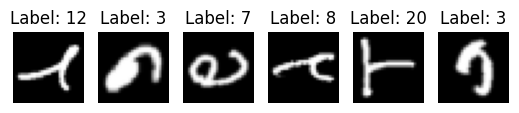

In [ ]:
show_images(train_dataset)

Preprocessing

In [ ]:
def preprocess_data(x, y):

    # normalize x
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x.reshape(x.shape[0], 28 * 28))
    x = x.reshape(x.shape[0], 28 * 28)

    # reduce each value in y by 1, so that the range of y is [0, 25]
    y = y - 1

    # convert class labels to one-hot encoded, should have shape (?, 26, 1)
    # 26 classes: 26 letters, for example, C is 3rd letter, then C is represented as [0, 0, 1, 0, 0, ...]
    y = np.eye(26)[y]

    y = y.reshape(y.shape[0], 26)

    return x, y


In [89]:
X = np.array([np.array(x[0]).flatten() for x in train_dataset])
Y = np.array([x[1] for x in train_dataset])

X_validation = np.array([np.array(x[0]).flatten() for x in validation_dataset])
Y_validation = np.array([x[1] for x in validation_dataset])

X_test = np.array([np.array(x[0]).flatten() for x in independent_test_dataset])
Y_test = np.array([x[1] for x in independent_test_dataset])


X, Y = preprocess_data(X, Y)
X_validation, Y_validation = preprocess_data(X_validation, Y_validation)
X_test, Y_test = preprocess_data(X_test, Y_test)

Train the model

In [ ]:
class NetworkModel:
    """
    The neural network model class

    Attributes:
        layers: The layers of the model
        loss_func: The loss function of the model
        optimizer: The optimizer of the model

    Methods:
        forward: The forward pass of the model
        backward: The backward pass of the model
        update: Updates the parameters of the model
        fit: Trains the model
        predict: Predicts the output of the model
        evaluate: Evaluates the model
    """

    def __init__(self, layers, loss_func, loss_func_prime, optimizer):
        """
        The constructor for the neural network model class

        Parameters:
            layers: The layers of the model
            loss_func: The loss function of the model
            optimizer: The optimizer of the model
        """

        
        self.layers = layers
        self.loss_func = loss_func
        self.loss_func_prime = loss_func_prime
        self.optimizer = optimizer

    def forward(self, input, training = True):
        """
        The forward pass of the model

        Parameters:
            input: The input to the model

        Returns:
            The output of the model
        """

        # print ("in forward")
        # print ("input shape: ", input.shape)

        for layer in self.layers:
            if isinstance(layer, DropoutLayer):
                input = layer.forward(input, training=training)

            else:
              input = layer.forward(input)
        # print ("output shape: ", input.shape)

        return input

    def backward(self, output_grad, y_label):
        """
        The backward pass of the model

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the model
            y_label: The ground truth

        Returns:
            The gradient of the loss w.r.t. the input of the model
        """

        # print ("in backward")
        # print ("output_grad shape: ", output_grad.shape)

        for layer in reversed(self.layers):
            if isinstance(layer, SoftmaxLayer):
                output_grad = layer.backward(output_grad, y_label)

            else:
                output_grad = layer.backward(output_grad)


        # print ("input_grad shape: ", output_grad.shape)

        return output_grad

    def update(self):
        """
        Updates the parameters of the model
        """

        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                self.optimizer.update(layer)

    def fit(self, x_train, y_train, x_validation, y_validation, epochs, batch_size):
        """
        Trains the model

        Parameters:
            x_train: The training input
            y_train: The training ground truth
            x_validation: The validation input

        """

        # print ("in fit")
        # print ("x_train shape: ", x_train.shape)
        # print ("y_train shape: ", y_train.shape)

        num_batches = math.ceil(x_train.shape[0] / batch_size)

        self.train_losses = []
        self.validation_losses = []

        self.train_accuracy_list = []
        self.validation_accuracy_list = []

        self.train_f1_list = []
        self.validation_f1_list = []

        random.seed(82)
        # shuffle the training data
        zipped_data = list(zip(x_train, y_train))
        random.shuffle(zipped_data)

        # print ("num_batches: ", num_batches)
        # print ("batch_size: ", batch_size)
        # print ("data size: ", len(zipped_data))

        for epoch in range(epochs):
            train_loss = 0
            validation_loss = 0
            train_accuracy = 0
            

            for i in tqdm(range(num_batches)):
                
                batch = zipped_data[i * batch_size : (i + 1) * batch_size]
                # unzip the minibatch
                x_batch, y_batch = zip(*batch)


                x_batch = np.array(x_batch).T
                y_batch = np.array(y_batch).T
                

                # print ("x_batch shape: ", x_batch.shape)
                # print ("y_batch shape: ", y_batch.shape)

                # forward pass
                y_pred = self.forward(x_batch, training=True)

                # print ("y_pred shape: ", y_pred.shape)

                # compute loss
                train_loss += self.loss_func(y_batch, y_pred)

                # print ("train_loss: ", train_loss)

                # backward pass
                output_grad = self.loss_func_prime(y_batch, y_pred)
                self.backward(output_grad, y_batch)

                # update parameters
                self.update()

            # validation
            y_validation_pred = self.forward(x_validation.T, training = False)
            validation_loss = self.loss_func(y_validation.T, y_validation_pred)

            train_accuracy, train_f1 = self.get_accuracy_f1(x_train.T, y_train.T)
            validation_accuracy, validation_f1 = self.get_accuracy_f1(x_validation.T, y_validation.T)

            self.train_accuracy_list.append(train_accuracy)
            self.validation_accuracy_list.append(validation_accuracy)

            self.train_f1_list.append(train_f1)
            self.validation_f1_list.append(validation_f1)

            self.train_losses.append(train_loss/num_batches)
            self.validation_losses.append(validation_loss)

            # print(f'Epoch: {epoch + 1}, Train loss: {train_loss}, Validation loss: {validation_loss}')

        return self.train_losses, self.validation_losses, self.train_accuracy_list, self.validation_accuracy_list, self.train_f1_list, self.validation_f1_list

    def get_accuracy_f1(self, x_test, y_test):
            
        y_test_pred = self.forward(x_test, training = False)

        y_test_pred = np.argmax(y_test_pred, axis=0)
        y_test = np.argmax(y_test, axis=0)

        return accuracy_score(y_test, y_test_pred) , f1_score(y_test, y_test_pred, average='macro')
    
    def predict(self, x_test, training = True):

        y_test_pred = self.forward(x_test, training=training)

        return y_test_pred

    
    def evaluate(self, X_test, Y_test):
        # test the model
        y_test_pred = self.predict(X_test, training = False)
        test_loss = self.loss_func(Y_test, y_test_pred)

        y_test_pred = np.argmax(y_test_pred, axis=0)
        y_test = np.argmax(Y_test, axis=0)

        print ("accuracy: ", accuracy_score(y_test, y_test_pred))
        print ("precision: ", precision_score(y_test, y_test_pred, average='macro'))
        print ("recall: ", recall_score(y_test, y_test_pred, average='macro'))
        print ("f1 score: ", f1_score(y_test, y_test_pred, average='macro'))

        conf_mat = confusion_matrix(y_test, y_test_pred)

        # Create a heatmap for the confusion matrix
        plt.figure(figsize=(14, 14))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
                    
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


    def plot_graph(self, data1, data2, title, label1, label2):

        plt.plot(data1, label = label1)
        plt.plot(data2, label = label2)
        plt.title(title)
        plt.legend()
        plt.show()

    def write_csv_report(self, model_name):
        # write the train_losses, validation_losses, train_accuracy_list, validation_accuracy_list, train_f1, validation_f1 in separate csv files
        import csv

        # write losses in a single csv file
        with open(f'losses_{model_name}.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["train_losses", "validation_losses"])
            for i in range(len(self.train_losses)):
                writer.writerow([self.train_losses[i], self.validation_losses[i]])

        # write accuracies in a single csv file
        with open(f'accuracies_{model_name}.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["train_accuracy_list", "validation_accuracy_list"])
            for i in range(len(self.train_accuracy_list)):
                writer.writerow([self.train_accuracy_list[i], self.validation_accuracy_list[i]])

        # write f1 scores in a single csv file
        with open(f'f1_scores_{model_name}.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["train_f1", "validation_f1"])
            for i in range(len(self.train_f1_list)):
                writer.writerow([self.train_f1_list[i], self.train_f1_list[i]])

 

the three different models

In [ ]:
learning_rate = 5e-4
model2 = NetworkModel(
    layers=[
        DenseLayer('Dense1', 28 * 28, 1024),
        ReLUActivationLayer('ReLU1'),
        DropoutLayer('Dropout1', 0.3),
        DenseLayer('Dense2', 1024, 26),
        SoftmaxLayer('Softmax')
    ],
    loss_func=cross_entropy_loss,
    loss_func_prime=cross_entropy_loss_prime,
    optimizer=AdamOptimizer(learning_rate= learning_rate)
)

train_losses, validation_losses, train_accuracy_list, validation_accuracy_list, train_f1, validation_f1 = model2.fit(X, Y, 
                                                                                                                   X_validation, Y_validation, epochs=4, batch_size=512)

model2.evaluate(X_test.T, Y_test.T)
model2.write_csv_report(f"model2_LR_{learning_rate}")

In [ ]:
learning_rate = 5e-4
model2 = NetworkModel(
    layers=[
        DenseLayer('Dense1', 28 * 28, 1024),
        ReLUActivationLayer('ReLU1'),
        DropoutLayer('Dropout1', 0.2),
        DenseLayer('Dense2', 1024, 26),
        SoftmaxLayer('Softmax')
    ],
    loss_func=cross_entropy_loss,
    loss_func_prime=cross_entropy_loss_prime,
    optimizer=AdamOptimizer(learning_rate= learning_rate)
)

train_losses, validation_losses, train_accuracy_list, validation_accuracy_list, train_f1, validation_f1 = model2.fit(X, Y, 
                                                                                                                   X_validation, Y_validation, epochs=4, batch_size=1024)

model2.evaluate(X_test.T, Y_test.T)
model2.write_csv_report(f"model2_LR_{learning_rate}")

In [ ]:
model3 = NetworkModel(
    layers=[
        DenseLayer('Dense1', 28 * 28, 1024),
        ReLUActivationLayer('ReLU1'),
        DropoutLayer('Dropout1', 0.2),
        DenseLayer('Dense2', 1024, 26),
        SoftmaxLayer('Softmax')
    ],
    loss_func=cross_entropy_loss,
    loss_func_prime=cross_entropy_loss_prime,
    optimizer=AdamOptimizer(learning_rate= 5e-3)
)

train_losses, validation_losses, train_accuracy_list, validation_accuracy_list, train_f1, validation_f1 = model3.fit(X, Y, 
                                                                                                                   X_validation, Y_validation, epochs=4, batch_size=1024)
model3.evaluate(X_test.T, Y_test.T)
model3.write_csv_report("model3")


Save the best model in pickle format

In [ ]:

model = model2

In [ ]:


weights_layer_1, biases_layer_1 = model.layers[0].weights, model.layers[0].bias
weights_layer_2, biases_layer_2 = model.layers[3].weights, model.layers[3].bias

data_to_save = {
    'weights_layer_1': weights_layer_1,
    'biases_layer_1': biases_layer_1,
    'weights_layer_2': weights_layer_2,
    'biases_layer_2': biases_layer_2
}

with open('model.pickle', 'wb') as model_file:
    pickle.dump(data_to_save, model_file)

